# 2024: Reconocimiento de habla con Dynamic Time warping, dependiente de locutor, multilocutor e independiente del locutor: Segunda Parte

Reconocedor de habla  Nearest Neighbor implementado con  DTW + MFCC.

Práctica adaptada por J.M.Pardo

# Reconocimiento dependiente del locutor
Debemos grabar una base de datos y subirla al directorio /content/.
Para ello, grabaremos en nuestro ordenador las siguientes 9 palabras:
  
  bata, caca,  cara, cata, paca, pata, para, vaca, vara

La grabación de cada  palabra se hará al menos dos veces (mejor 4 o 6 ).
Inicialmente la prueba será con un solo locutor (dependiente del locutor) pero posteriormente (ver abajo) podremos elegir más de un locutor para cada palabra.

Una vez grabadas, debemos convertirlas a formato *.wav. Para el caso en el que no estén en ese formato  usar un convertidor en linea, por ejemplo https://online-audio-converter.com/es/

Hay seguir una nomenclatura determinada para cada grabación para no tener confusiones, por ejemplo paca_xxx_1.wav sería el nombre de la  primera grabación de la palabra "paca" por el locutor con iniciales "xxx" Iniciales con minúsculas.

Una vez tengamos las grabaciones separadas por palabras, haremos un .zip con todas ellas y crearemos un fichero comprimido llamado por ejemplo practica.zip

Muy importante es darnos cuenta de que los audios grabados tenemos que tenerlos siempre grabados y salvados en nuestro ordenador (en este caso nuestro google drive)  y subirlos a google-colab cuando vayamos a hacer la práctica, ya que una vez que nos hayamos desconectado del entorno de ejecución, todos los audios que hayamos subido desaparecerán.



In [ ]:
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')
import zipfile
import os






# Introducción

El reconocimiento **dependiente de locutor** implica que todas las grabaciones que hagamos corresponden a un solo locutor.

El reconocimiento **multilocutor** implica que todas las grabaciones que hagamos proceden de varios locutores pero tanto las grabaciones para entrenamiento (train) como las de  los tests de prueba (llamados aqui de validación) también contienen todos los locutores. Comparamos las grabaciones de validación con todos los locutores.

El reconocimiento **independiente del locutor** significa que las grabaciones de entrenamiento proceden de unos locutores (idealmente muchos) y las de validacion de otros (distintos a los anteriores)

In [ ]:
%matplotlib inline
# se establece una configuración especial para que las figuras de Matplotlib se muestren dentro del notebook

import glob
import librosa
import numpy as np
!pip install dtw # instalamos el programa de comparación y extracción del alineamiento
from dtw import dtw, accelerated_dtw

In [ ]:

# Obtener el directorio de trabajo actual
#directorio_actual = os.getcwd()

# Imprimir el directorio actual
# print("Directorio actual:", directorio_actual)

directorio = '/content/drive/MyDrive/Colab Notebooks/ph/2023/PH-dtw-grabaciones/' #cambiar el nombre del directorio al directorio personal

print("Directorio actual:", directorio)
# Listar archivos en el directorio
archivos = os.listdir(directorio)

# Imprimir la lista de archivos
print ("Archivos:")
for archivo in archivos:
    print(archivo)



In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/ph/2023/PH-dtw-grabaciones/mis_audios.zip'  #ponga aqui el fichero .zip que contiene todos los audios

In [ ]:
DATABASE_PATH = '/content/'

In [ ]:

labels = ["bata","caca","cara","cata","paca","para","pata","vaca","vara"]  # lista ordenada indexable


In [ ]:
# El valor de N es el número de grabaciones hechas y subidas por cada palabra
# si hemos hecho dos grabaciones, aqui pondremos 2 y si hemos hecho otro valor (par), pondremos ese valor
N = 2

## Precompute all MFCCs

La siguiente celda lo que hace es calcular los parámetros Mel Frequency Cepstrum de todos los ficheros subidos. Por defecto se calculan 20 coeficientes mfcc

In [ ]:
mfccs = [] # esta será una lista que contiene todas las grabaciones, una detrás de otra
true_labels = [] # esta serña una lista de las etiquetas "palabras" de cada una de las grabaciones

for l in labels:
  print (l)



for l in  range(9): # la variable l itera sobre las etiquetas listadas arriba
    str = labels[l]
    sound = glob.glob(os.path.join(DATABASE_PATH, str, '*.wav'))  # ojo, el orden que crea aqui NO es alfabético por lo que los ficheros 1,2 etc
                                                                    # no están siempre en el mismo orden por lo que lo ordenamos en la siguiente línea
    sounds= sorted(sound)
    sounds = sounds[:N] # toma los primeros N elementos de la lista de una palabra determinada
    print (sounds) # esto nos servirá para ver el orden final de los audios creados.

    for s in sounds:
        y, sr = librosa.load(s)
        mfcc = librosa.feature.mfcc(y=y,sr=sr) # calculo los coeficientes mfcc para una grabación cuya forma de audio temporal esta en el vector y
                              # mfcc será una matriz filas-columnas en la que cada fila es un coeficiente mfcc y cada columna es una ventana temporal
        mfccs.append(mfcc.T) # añado los valores mfcc de cada grabación a una lista global. Hago la matriz traspuesta para que todas las líneas
                              # contengan el mismo número de columnas (20 = n. coeficientes mfcc)
        true_labels.append(str)
        #print(mfcc) esto es para debugging


true_labels = np.array(true_labels)

print("True labels",true_labels)


Fijémonos en el listado que aparece después de ejecutar la celda anterior.

En mi ejemplo son:
['/content/bata/bata_jmp_1.wav', '/content/bata/bata_jmp_2.wav']
['/content/caca/caca_jmp_2.wav', '/content/caca/caca_jmp_1.wav']
['/content/cara/cara_jmp_1.wav', '/content/cara/cara_jmp_2.wav']
['/content/cata/cata_jmp_2.wav', '/content/cata/cata_jmp_1.wav']
['/content/paca/paca_jmp_2.wav', '/content/paca/paca_jmp_1.wav']
['/content/para/para_jmp_2.wav', '/content/para/para_jmp_1.wav']
['/content/pata/pata_jmp_2.wav', '/content/pata/pata_jmp_1.wav']
['/content/vaca/vaca_jmp_1.wav', '/content/vaca/vaca_jmp_2.wav']
['/content/vara/vara_jmp_1.wav', '/content/vara/vara_jmp_2.wav']

Por un lado nos aparece los nombres de los ficheros de audio y finalmente nos aparecen las etiquetas de cada palabra pronunciada.

En mi ejemplo son:

['bata' 'bata' 'caca' 'caca' 'cara' 'cara' 'cata' 'cata' 'paca' 'paca'
 'para' 'para' 'pata' 'pata' 'vaca' 'vaca' 'vara' 'vara']

 El orden de estas etiquetas desde 0 a 17 (para el caso de dos grabaciones por palabra) nos va a marcar la etiqueta de la palabra que se ha pronuciado.

Por ejemplo,  la primera etiqueta es 'bata', el indice 0 (que luego usaremos) se refiere a la palabra pronunciada 'bata' y al fichero correspondiente bata_jmp_1.wav que tenemos en primer lugar . La segunda es 'bata' se refiere al índice 1 y al segundo fichero bata_jmp_2.wav que nos aparece en el listado en segunda posición. La  tercera es 'vara' esto se corresponderá al indice 2 y al fichero vara_jmp_1.wav. Si hubiéramos grabado 4 audios por palabra, las primeras 4 etiquetas corresponderían a la primera palabra y los índices serían 0,1,2,3 y los audios correspondientes serían los que aparecerían en los listados.

Es muy importante que asociemos los índices a los ficheros de audio, pues despues tendremos que elegir unos para validacion (test) y otros para entrenamiento (train)

## Prepare train/val dataset

 En este momento, es importante crear los valores de los arrays de I_val e I_train
estos arrays contienen los índices de las palabras a reconocer (I_val) y las palabras grabadas (I_train)
 para asignarlos, debemos fijarnos en la salida de la celda anterior, donde aparecen en orden los audios de cada palabra
 en este ejemplo particular, tenemos dos grabaciones por palabra, y hemos asignado la primera grabación (indices pares)
a la validación (test) y la segunda (índices impares) a la grabación de entrenamiento. En el caso de que hubieramos grabado , por ejemplo, 4 audios por palabra
los valores serían por ejemplo I_val=[0,1,4,5,8,9....] e I_train=[2,3,6,7,10,11,...] donde hemos elegido las dos primeras
a la validación y las dos segundas a la grabación de entrenamiento

I_val= [0,2,4,6,8,10,12,14,16]
I_train= [1,3,5,7,9,11,13,15,17]
I_val= [0,2,4,6,8,10,12,14,16] # estos índices corresponden a la primera grabación de cada palabra por ejemplo
I_train= [1,3,5,7,9,11,13,15,17] # estos índices corresponden a la segunda grabación de cada palabra por ejemplo

In [ ]:
# Los índicces I_val e I_train puede generarlos a mano como le ponemos abajo
I_val= [0,2,4,6,8,10,12,14,16] # estos índices corresponden a la primera grabación de cada palabra por ejemplo
I_train= [1,3,5,7,9,11,13,15,17] # estos índices corresponden a la segunda grabación de cada palabra por ejemplo


# O bien, le añadimos aquí una manera de generar estos índices concretos
I_val =[]
I_train = []

for i in range(9):
  I_val.append(i*2)
  I_train.append(i*2+1)

print (I_val, I_train)

[0, 2, 4, 6, 8, 10, 12, 14, 16] [1, 3, 5, 7, 9, 11, 13, 15, 17]


## Cross Validation

La siguiente celda, simplemente define la función que se va a ejecutar.
La función dtw es la que realiza el alineamiento dinámico temporal y la función
cross_validation devuelve las palabras pronunciadas y reconocidas y la tasa de acierto

In [ ]:


def cross_validation(train_indices, val_indices):
    score = 0.0

    for i in val_indices:
        x = mfccs[i]


        dmin, jmin = np.inf, -1
        for j in train_indices:
            y = mfccs[j]
            d, _, _, _ = dtw(x, y, dist=lambda x, y: np.linalg.norm(x - y, ord=1)) # distancia absoluta
            #d, _, _, _ = accelerated_dtw(x, y, 'cosine') # distancia coseno

            if d < dmin:
                dmin = d
                jmin = j

        score += 1.0 if (true_labels[i] == true_labels[jmin]) else 0.0
        actual.append(true_labels[i])
        predicted.append (true_labels[jmin])
        print ("pronunciada =", true_labels[i], "     reconocida =",true_labels[jmin] )

    return score / len(val_indices)

Ejecute la celda de abajo para obtener la tasa de reconocimiento y los valores pronunciados y reconocidos. Descomente la línea con la funcion accelerated_dtw y comente la dtw y obtenga el mismo resultado pero ahora con la distancia coseno.

In [ ]:
# realiza el reconocimiento de las palabras que están en el grupo de validación
#frente a las que están en el grupo de train

actual =[]
predicted =[]

rec_rate = cross_validation(I_train, I_val)
print('Recognition rate {}%'.format(100. * rec_rate))
print (actual)
print (predicted)

# Segunda tarea

Modifique las celdas anteriores y prográmelas para obtener también la distancia de reconocimiento en cada prueba.

Haga un comentario sobre el valor de las distancias obtenidas.

# Tercera Tarea
Una vez ejecutada la celda anterior, anotar la tasa de reconocimiento obtenida y crear la matriz de confusión que tendra una dimension de 9*9 celdas en la que veamos en el eje vertical las palabras pronunciadas y en el eje horizontal las reconocidas por cada una de las pronunciadas. Esto podremos hacerlo anotandolo a mano a partir del resultado obtenido de la ejecución de la celda anterior o bien haciendo un programa que lo haga. Será del estilo del dibujo de abajo.

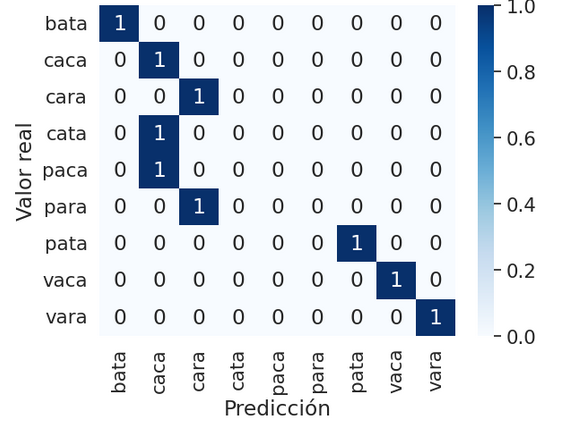

Una opción para hacerlo programado es usar las librerías seaborn y matplotlib

# Cuarta tarea

Con el otro script adjunto recorte la parte del silencio de los audios, grabe los audios recortados en google drive. Cree un nuevo .zip y a partir de ahi vuelva a ejecutar el script anterior

# Quinta tarea opcional
Opcionalmente, grabar más ejemplos de las palabras pronunciadas por mas de un locutor (por ejemplo usando las grabaciones de algún compañero) y rehacer el experimento. Es importante observar un control manual de qué indice de fichero de audio corresponde a qué locutor.

Aquí tendremos dos opciones:


1.   Reconocimiento multilocutor:  Tanto en la lista de validación (test) como la de entrenamiento (train) hay grabaciones de ambos locutores. Por ejemplo debería haber al menos dos grabaciones de palabras por cada locutor para que una sirviera para I_train y la otra para I_val.

2.   Reconocimiento independiente de locutor:  en la lista de  validacion hay un locutor y en entrenamiento otro diferente. Debemos controlar  las listas I_val e I_train adecuadas con los índices que correspondan

Abajo le damos algunas pistas de cómo generar listas para esos problemas


In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/ph/2023/PH-dtw-grabaciones/2023-audios-alumnos.zip' # cambiar el nombre del fichero .zip donde tenga sus grabaciones en su caso
# al descomprimir, se crean subdirectorios con los nombres de cada palabra y las grabaciones de las mismas en dichos directorios

In [ ]:
# El valor de N es el número de grabaciones hechas y subidas por cada palabra
# si hemos hecho dos grabaciones, aqui pondremos 2 y si hemos hecho otro valor (par), pondremos ese valor. Yo he puesto 12 por tener 12 grabaciones por palabra
N = 12

PRECOMPUTE MFCC

In [ ]:
# Ejemplo  de generacion de índices para hacer un reconocimiento  DEPENDIENTE DEL LOCUTOR

# suponemos que cada locutor tiene dos grabaciones la _1 y la _2. usaremos la grabación _1 para validación y la _2 para entrenamiento
I_val = []
I_train =[]

grabaciones_val=['1']
grabaciones_train=['2']

for clave, valor in dictionary.items ():
  print (clave, valor)

for grabacion in grabaciones_val :
  for clave, valor in dictionary.items ():

    if grabacion in clave:

      I_val.append(valor)

for grabacion in grabaciones_train :
  for clave, valor in dictionary.items ():

    if grabacion in clave:

      I_train.append(valor)
print (I_val)
print ( I_train)


In [ ]:
# EJEMPLO de Generación de índices para hacer un reconocimiento  INDEPENDIENTE DEL LOCUTOR
 # con 6 locutores y dos grabaciones por locutor y palabra
I_val = []
I_train =[]

speakers_val=['aiv','jmm','kmo']
speakers_train=['nem','pbo','pmm']

for clave, valor in dictionary.items ():
  print (clave, valor)

for speaker in speakers_val :
  for clave, valor in dictionary.items ():

    if speaker in clave:

      I_val.append(valor)

for speaker in speakers_train :
  for clave, valor in dictionary.items ():

    if speaker in clave:

      I_train.append(valor)
print (I_val)
print ( I_train)

Haga un zip con este notebook y con las grabaciones hechas y súbalo al buzón de entrega